# Maccabi HW



This notebook uses scripts (`utils.py`) to:
1. Load and normalize the dataset
2. Detect & drop leakage-prone columns by name
3. Train tabular + text models and late-fuse
4. Plot ROC, PR, Recall-vs-Budget, PPV-vs-Budget (each in its own figure)
5. Run a leakage-risk scan and plot top suspicious features

Notes:
- Plots use matplotlib only, one plot per figure, and no explicit colors.




In [9]:

# --- Parameters ---
DATA_PATH = "/content/ds_assignment_data.csv"     # change if needed
TARGET = "y"                              # or "target"
TEXT_COL_OVERRIDE = None                  #"clinical_sheet"; set to None to auto-detect
NO_TEXT = True                           # True to ignore text completely
TEST_SIZE = 0.2
SEED = 42
COST_PER_TEST = 120.0

# selection: use exactly one of these; if both set, K_TARGET takes precedence
K_TARGET = 200
BUDGET_USD = None

TOPN_LEAKAGE = 30                         # show top-N suspicious features in scan


In [10]:

# --- Imports ---
import os, sys, shutil, importlib , re, json, numpy as np, pandas as pd, matplotlib
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

#
sys.path.insert(0, "/content/")
import utils
# 2) If an old utils was already imported, drop it from cache
if "utils" in sys.modules:
    del sys.modules["utils"]
#Import the fresh file
import utils
importlib.reload(utils)                   # force reload just in case

try:
    import leakage_risk_scan as lrs
except Exception:
    lrs = None

# Hebrew rendering
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

pd.set_option("display.max_colwidth", None)


# Functions



In [11]:

# --- Helpers aligned with your scripts ---
LEAK_NAME_RE = re.compile(utils.SUSPECT_NAME_RE, re.IGNORECASE)

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    return utils.normalize_columns(df)


def drop_leakage(df: pd.DataFrame, target: str, text_col: str = None) -> pd.DataFrame:
    keep = [target]
    for c in df.columns:
        if c == target:
            continue
        if text_col and c == text_col:
            keep.append(c); continue
        if LEAK_NAME_RE.search(c):
            continue
        keep.append(c)
    return df[keep].copy()

def metrics(y, p):
    return {"roc_auc": float(roc_auc_score(y, p)), "pr_auc": float(average_precision_score(y, p))}

def recall_ppv_threshold_at_k(y_true: np.ndarray, y_score: np.ndarray, k: int):
    n = len(y_score)
    if k <= 0:
        return 0, 0.0, 0.0, 1.0
    k = min(k, n)
    order = np.argsort(-y_score)
    top = order[:k]
    thr = float(y_score[order[k-1]])
    tp = int(y_true[top].sum()); pos = int(y_true.sum())
    recall = float(tp/pos) if pos>0 else 0.0
    ppv = float(tp/k)
    return k, recall, ppv, thr


# Read data:

In [15]:

# --- Load & prepare ---
df = pd.read_csv(DATA_PATH)
df = normalize(df)

# Set important columns:
TARGET ='y'
df[TARGET] = df[TARGET].astype(int)
text_col = 'clinical_sheet'

df = drop_leakage(df, target=TARGET, text_col=text_col)

print("Rows, Cols:", df.shape)
print("Target column:", TARGET, "Text column:", text_col)


Rows, Cols: (10000, 143)
Target column: y Text column: clinical_sheet


# Simple EDA:

********** Simple EDA **********

Data INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 143 entries, y to clinical_sheet
dtypes: float64(95), int64(47), object(1)
memory usage: 10.9+ MB

Shape
: (10000, 143)

Dtypes Counts: float64    95
int64      47
object      1
Name: count, dtype: int64
Label	arget column name: y
Target prevalence: 4.320%

=== PLOT: Columns with >10% missing (Top 5) ===

Number of columns with >10% missing values: 57


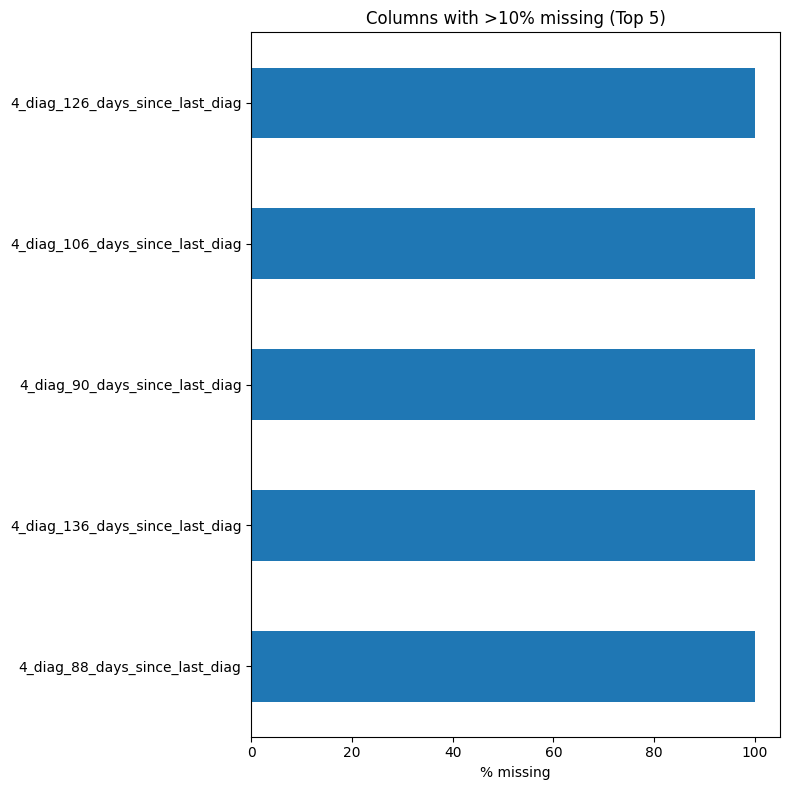

Number of numeric columns: 142 Number of categorical columns: 1

(Name if categorical - Text column is: clinical_sheet)

(Describe text column:)
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [16]:
utils.simple_eda(df)

## EDA (Text column) :

In [17]:
# build sections from text 7 section(recommendations,vitals,medications,labs_imaging,findings,risk_factors,complaints)
# and match earlest week reported and relevant text under the section for future use in model (only relevant txt sections)
d = df[[text_col]].copy()
d["row_id"] = np.arange(len(d))
d["secs"]   = d[text_col].apply(utils.parse_canon_sections_all)

d = d.explode("secs").dropna(subset=["secs"]).reset_index(drop=True)
canon_secs = d.join(pd.json_normalize(d["secs"])).drop(columns=["secs"])

canon_secs = canon_secs[canon_secs["canon"].notna()].copy()
canon_secs = canon_secs.sort_values(["row_id","ord"], kind="stable").reset_index(drop=True)
canon_secs["week"] = pd.to_numeric(canon_secs["week"], errors="coerce").astype("Int64")

SECTION_DF = canon_secs  # used below


In [19]:
#quick header candidates scan
all_heads = []
for t in df[text_col].fillna(""):
    all_heads.extend(utils.candidate_headers(t))

cnt = Counter(all_heads)
print("Top header candidates:")
for h, n in cnt.most_common(10):
    print(f"{n:>4}  {h}")


Top header candidates:
7854  המלצות
4961  ממצאי בדיקה
4271  גורמי סיכון
3408  תלונות
3033  תוצאות מעבדה
2756  תלונות המטופלת
2604  ממצאים בבדיקה
1434  בדיקה גופנית
1432  מעבדה
1167  בדיקות מעבדה


In [20]:
#  sentences table -> positives -> top n-grams
sentences   = utils.split_to_sentences(SECTION_DF)
sentences_y = utils.attach_target(sentences, df, TARGET)
pos_only    = sentences_y[sentences_y[TARGET] == 1].copy()

results = utils.top_ngrams_per_section(
    pos_only,
    ngram_range=(1,3),
    min_df=3,
    top_k=20,
    keep_bigrams_only=True
)

# utils.plot_top_ngrams_per_section(results, k=5)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['מטופלת', 'תרופתי'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['מטופלת', 'תרופתי'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['מטופלת', 'תרופתי'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['מטופלת', 'תרופתי'] not in stop_words.
 

In [21]:
# combined n-grams table
all_rows = []
for canon, df_top in results.items():
    x = df_top.copy()
    x["canon"] = canon
    all_rows.append(x)
ngrams_table = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame(columns=["ngram","count","canon"])
ngrams_table.head(10)


,ngram,count,canon
0,עייפות מוגברת,216,complaints
1,כאבי ראש,166,complaints
2,עייפות מוגברת ובחילות,86,complaints
3,מוגברת ובחילות,86,complaints
4,תחושת עייפות,84,complaints
5,ראש קלים,84,complaints
6,כאבי ראש קלים,76,complaints
7,שיפור בבחילות,73,complaints
8,מדי פעם,73,complaints
9,עייפות מתמשכת,65,complaints


In [22]:
# === Build leak-free text column from risk_factors + complaints only ===

# keep only these canons
CANON_KEEP = {"risk_factors", "complaints"}

##### optional - to delete words that can be leak - i assumed no leake info from txt based on task instruction
# leakage terms (expand as needed)
LEAK_TEXT_RE = re.compile(
    r"(סיכון קל לרעלת היריון עקב תוצאות |אקלמפסיה)",
    re.IGNORECASE
)
def _strip_leak(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = LEAK_TEXT_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t
######

# SECTION_DF must contain: ['row_id','canon','text', ...]  (you already have it)
sub = (SECTION_DF.loc[SECTION_DF["canon"].isin(CANON_KEEP), ["row_id","text"]]
                  .assign(text=lambda x: x["text"].fillna("").astype(str)))

agg = (sub.groupby("row_id", sort=False)["text"]
          .apply(lambda s: " ".join([u for u in s if u]))  # concat sections in original order
          .rename("text_risk_complaints_clean")
          .reset_index())

# join back to main df (row_id == positional index of df)
df = df.join(agg.set_index("row_id"), how="left")

# OPTIONAL: if your model should ignore the original text column:
# df_model = df.drop(columns=[text_col]).copy()
# and then use df_model["text_risk_complaints_clean"] as the only text input.


In [23]:
# Cell 7: risk-factor feature extraction from canons (configure your LEXICON here)
CANONS = {"risk_factors","complaints","findings","labs_imaging","vitals","recommendations"}

LEXICON = {  # ← keep/update from EDA
    "diabetes":[r"\bסוכרת\b",r"\bסכרת\b",r"\bT2DM\b",r"\bDM\b",r"סוכרת\s*סוג\s*2",r"\bHbA1c\b",r"\bאינסולין\b"],
    "chronic_hypertension":[r"יתר\s*לחץ\s*דם\s*כרוני",r"\bHTN\b",r"\bיל\"ד\b",r"לחץ\s*דם\s*גבוה.*לפני"],
    "ckd":[r"מחלת\s*כליה\s*כרונית",r"אי\s*ספיקת\s*כליות",r"\bCKD\b",r"קריאטינין\s*גבוה",r"אלבומינוריה"],
    "proteinuria":[r"חלבון\s*בשתן",r"פרוטאינוריה",r"חלבון\+{1,3}",r"300\s*מ\"ג\s*ב-?24\s*שעות"],
    "lupus":[r"\bזאבת\b",r"\bSLE\b",r"\bלופוס\b"],
    "ivf":[r"\bIVF\b",r"הפריה\s*חוץ\s*גופית",r"טיפולי\s*פוריות",r"החזרת\s*עוברים"],
    "twins":[r"\bתאומים\b",r"הריון\s*מרובה\s*עוברים",r"שני\s*עוברים",r"שתי\s*שקים"],
    "family_history_pe": [ r"(סיפור\s*משפחתי|היסטוריה\s*משפחתית|במשפחה|רעלת\s*במשפחה|אמא\s*עם|אחות\s*עם)"
    r"\s*(של\s*)?רעלת(?:\s*הריון)? "],
    "prior_hypertensive_pregnancy":[r"רעלת\s*בהריון\s*קודם",r"\bHELLP\b",r"יתר\s*לחץ\s*דם\s*הריוני\s*בעבר"],
    "primigravida":[r"הריון\s*ראשון",r"\bG1P0\b",r"ללא\s*לידות\s*קודמות"],
    "maternal_age_ge40":[r"גיל\s*40\s*ומעלה",r"מעל\s*גיל\s*38"],
    "overweight_text":[r"\bBMI\s*(?:3[0-9]|[4-9]\d)\b|\bעודף\s*משקל\b",r"\bהשמנה\b"],
    "aspirin_use":[r"\bאספירין\b",r"\bASA\b",r"\bמיקרופירין\b",r"\bקרטיה\b",r"Astrix"]
}

cs = (SECTION_DF.query('canon in @CANONS')
      .assign(week=pd.to_numeric(SECTION_DF['week'],errors='coerce').astype('Int64'),
              text=SECTION_DF['text'].fillna('')))

union_rx = {k: re.compile("|".join(f"(?:{p})" for p in v)) for k,v in LEXICON.items()}
matches = pd.concat([cs.loc[cs['text'].str.contains(rx, regex=True), ['row_id','week']].assign(key=k)
                     for k,rx in union_rx.items()], ignore_index=True)

if matches.empty:
    kw_feats = pd.DataFrame({"row_id": cs['row_id'].unique()})
else:
    present = matches.groupby(['row_id','key'])['week'].min().reset_index(name='week_min')
    wide_flag = (present.assign(val=1).pivot(index='row_id',columns='key',values='val')
                 .fillna(0).astype('Int64').add_prefix('kw_'))
    wide_week = (present.pivot(index='row_id',columns='key',values='week_min')
                 .astype('Int64').add_prefix('kw_').add_suffix('_week'))
    kw_feats = wide_flag.join(wide_week).reset_index()

risk_keys = [k for k in LEXICON if k!='aspirin_use']
flag_cols = [f"kw_{k}" for k in risk_keys if f"kw_{k}" in kw_feats]
week_cols = [f"kw_{k}_week" for k in risk_keys if f"kw_{k}_week" in kw_feats]
kw_feats["risk_flag_any"] = (kw_feats[flag_cols].max(axis=1).astype('Int64') if flag_cols else 0)
kw_feats["risk_week_min"] = (kw_feats[week_cols].min(axis=1).astype('Int64') if week_cols else pd.NA)

kw_feats.head(10)


/tmp/ipython-input-627917494.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = pd.concat([cs.loc[cs['text'].str.contains(rx, regex=True), ['row_id','week']].assign(key=k)


key,row_id,kw_chronic_hypertension,kw_ckd,kw_diabetes,kw_family_history_pe,kw_ivf,kw_lupus,kw_overweight_text,kw_primigravida,kw_proteinuria,...,kw_diabetes_week,kw_family_history_pe_week,kw_ivf_week,kw_lupus_week,kw_overweight_text_week,kw_primigravida_week,kw_proteinuria_week,kw_twins_week,risk_flag_any,risk_week_min
0,1,0,0,1,0,0,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>
1,5,0,0,1,0,0,0,0,0,0,...,11,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,11
2,6,0,0,1,0,0,0,0,0,0,...,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,12
3,14,0,0,1,0,0,0,0,0,0,...,13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,13
4,20,0,0,0,0,0,0,0,0,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15,<NA>,1,15
5,23,0,0,0,0,0,0,1,0,0,...,<NA>,<NA>,<NA>,<NA>,12,<NA>,<NA>,<NA>,1,12
6,25,0,0,0,0,0,0,0,0,1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8,<NA>,1,8
7,30,0,0,0,0,0,0,0,1,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,8,<NA>,<NA>,1,8
8,34,0,0,1,0,0,0,0,0,0,...,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,12
9,42,0,0,1,0,0,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,<NA>


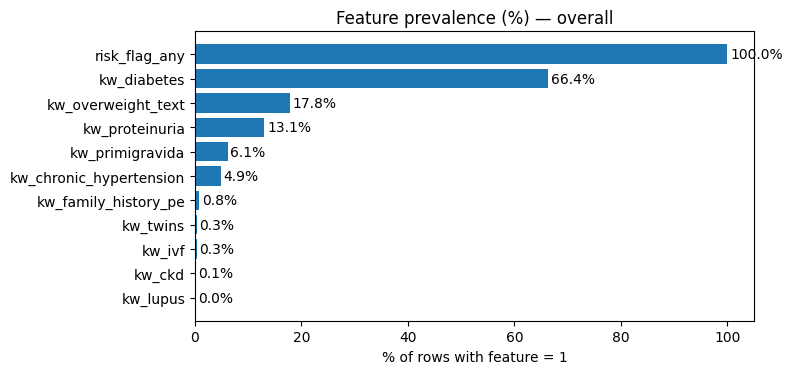

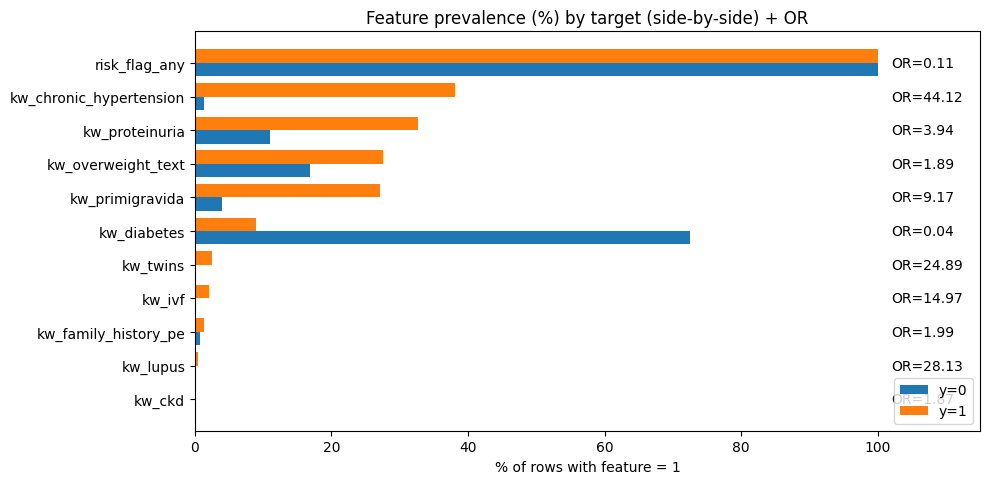

In [24]:
# === Two plots: (1) overall prevalence, (2) side-by-side by TARGET + OR ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- collect binary feature columns (kw_*) ---
flag_cols_all = [c for c in kw_feats.columns if c.startswith("kw_") and not c.endswith("_week")]
if "risk_flag_any" in kw_feats.columns:
    flag_cols_all.append("risk_flag_any")

if not flag_cols_all:
    raise ValueError("No binary kw_* feature columns found in kw_feats.")

# -------- Plot 1: overall prevalence (%=1) ----------
prev = (kw_feats[flag_cols_all].fillna(0).astype(float).mean() * 100).sort_values()

plt.figure(figsize=(8, max(3, 0.35*len(prev))))
plt.barh(prev.index, prev.values)
plt.xlabel("% of rows with feature = 1")
plt.title("Feature prevalence (%) — overall")
for i, v in enumerate(prev.values):
    plt.text(v + 0.5, i, f"{v:.1f}%", va="center")
plt.tight_layout()
plt.show()

# -------- Plot 2: prevalence by TARGET (side-by-side) + Odds Ratio ----------
if "row_id" not in kw_feats.columns:
    raise ValueError("'row_id' is required in kw_feats to merge with df[TARGET].")
if TARGET not in df.columns:
    raise ValueError(f"TARGET column '{TARGET}' not found in df.")

# merge TARGET by row_id (assumes df index == original row_id)
tmp = kw_feats[["row_id"] + flag_cols_all].merge(
    df[[TARGET]].reset_index().rename(columns={"index": "row_id"}),
    on="row_id", how="left"
)
tmp[TARGET] = pd.to_numeric(tmp[TARGET], errors="coerce").fillna(0).astype(int)

# prevalence table (%)
by_y = (tmp.groupby(TARGET)[flag_cols_all].mean() * 100).T  # rows=features, cols={0,1}
if 0 not in by_y.columns: by_y[0] = 0.0
if 1 not in by_y.columns: by_y[1] = 0.0
by_y = by_y[[0, 1]]  # fixed column order
by_y = by_y.sort_values(1)  # sort by prevalence in Y=1

# OR with Haldane–Anscombe correction (+0.5)
counts1 = (tmp[tmp[TARGET] == 1][flag_cols_all].sum()).astype(int)
n1 = int((tmp[TARGET] == 1).sum())
counts0 = (tmp[tmp[TARGET] == 0][flag_cols_all].sum()).astype(int)
n0 = int((tmp[TARGET] == 0).sum())

def odds_ratio_haldane(a, b, c, d):
    # 2x2 table: a=Y1&F1, b=Y0&F1, c=Y1&F0, d=Y0&F0
    a, b, c, d = a + 0.5, b + 0.5, c + 0.5, d + 0.5
    return (a * d) / (b * c)

or_vals = {}
for f in flag_cols_all:
    a = int(counts1.get(f, 0))  # Y=1 & feature=1
    b = int(counts0.get(f, 0))  # Y=0 & feature=1
    c = n1 - a                  # Y=1 & feature=0
    d = n0 - b                  # Y=0 & feature=0
    or_vals[f] = odds_ratio_haldane(a, b, c, d)

# side-by-side bars (not stacked)
y_pos = np.arange(len(by_y))
width = 0.4
plt.figure(figsize=(10, max(3, 0.45*len(by_y))))
plt.barh(y_pos - width/2, by_y[0].values, height=width, label=f"{TARGET}=0")
plt.barh(y_pos + width/2, by_y[1].values, height=width, label=f"{TARGET}=1")

plt.yticks(y_pos, by_y.index)
plt.xlabel("% of rows with feature = 1")
plt.title("Feature prevalence (%) by target (side-by-side) + OR")

# add OR text to the right
xmax = float(np.max(np.concatenate([by_y[0].values, by_y[1].values]))) if len(by_y) else 100.0
for i, feat in enumerate(by_y.index):
    or_val = or_vals.get(feat, np.nan)
    if np.isfinite(or_val):
        plt.text(xmax + 2, i, f"OR={or_val:.2f}", va="center")

plt.legend(loc="lower right")
plt.xlim(0, xmax + 15)  # margin for OR labels
plt.tight_layout()
plt.show()


## Feature ENG:

In [25]:
## create binary column for the daignosis icd codes + after del all columns that have >99% missing:
days_cols = [c for c in df.columns if "days_since_last_diag" in c]

for col in days_cols:
    new_col = col.replace("days_since_last_diag", "ever_had_diag")
    df[new_col] = (~df[col].isna()).astype(int)

# % missing per column
miss = df.isna().mean().mul(100)
# find cols with >99% missing
cols_to_drop = miss[miss > 99].index.tolist()
# drop them
df = df.drop(columns=cols_to_drop)
print("Dropped columns:", cols_to_drop)

Dropped columns: ['24_diag_53_days_since_last_diag', '24_diag_57_days_since_last_diag', '24_diag_65_days_since_last_diag', '24_diag_73_days_since_last_diag', '24_diag_75_days_since_last_diag', '24_diag_77_days_since_last_diag', '24_diag_83_days_since_last_diag', '4_diag_88_days_since_last_diag', '4_diag_90_days_since_last_diag', '4_diag_96_days_since_last_diag', '4_diag_98_days_since_last_diag', '4_diag_102_days_since_last_diag', '4_diag_106_days_since_last_diag', '4_diag_108_days_since_last_diag', '4_diag_110_days_since_last_diag', '4_diag_114_days_since_last_diag', '4_diag_118_days_since_last_diag', '4_diag_120_days_since_last_diag', '4_diag_126_days_since_last_diag', '4_diag_130_days_since_last_diag', '4_diag_136_days_since_last_diag', '4_diag_138_days_since_last_diag']


In [26]:
# Get units Normalization if needed:
lab_unit_normal = utils.UnitNormalizer()
lab_unit_normal.fit(df).transform(df)
# add binary flags as features using lab results known limits
flagger = utils.BinaryFlagsAdding()
df = flagger.add_flags(df)
print('The following binary flags for lab results created:')
print([c for c in df.columns if "flag" in c])

df = utils.add_new_features(df)

The following binary flags for lab results created:
['WBC_low_flag', 'WBC_high_flag', 'HGB_low_flag', 'HGB_high_flag', 'HCT_low_flag', 'HCT_high_flag', 'PLT_low_flag', 'PLT_high_flag', 'MPV_low_flag', 'MPV_high_flag', 'MCH_low_flag', 'MCH_high_flag', 'MCHC_low_flag', 'MCHC_high_flag', 'RDW_low_flag', 'RDW_high_flag', 'age_over_38_flag']


In [27]:

# --- Split ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
tr_idx, te_idx = next(sss.split(df, df[TARGET]))
tr, te = df.iloc[tr_idx].copy(), df.iloc[te_idx].copy()
text_col = 'text_risk_complaints_clean'
X_tr_all, y_tr = tr.drop(columns=[TARGET]), tr[TARGET].to_numpy()
X_te_all, y_te = te.drop(columns=[TARGET]), te[TARGET].to_numpy()

if text_col and text_col in X_tr_all.columns:
  # only text feature
    X_tr_txt = X_tr_all[text_col].astype(str)
    X_te_txt = X_te_all[text_col].astype(str)
    # only tabular features
    X_tr_tab = X_tr_all.drop(columns=[text_col])
    X_te_tab = X_te_all.drop(columns=[text_col])
else:
    X_tr_txt = None; X_te_txt = None
    X_tr_tab = X_tr_all; X_te_tab = X_te_all

print("Tabular shape:", X_tr_tab.shape, "Text used:", X_tr_txt is not None)


Tabular shape: (8000, 189) Text used: True


In [28]:

# --- Train models ---
from sklearn.ensemble import HistGradientBoostingClassifier

num_cols = [c for c in X_tr_tab.columns if np.issubdtype(X_tr_tab[c].dtype, np.number)]
cat_cols = [c for c in X_tr_tab.columns if c not in num_cols]

pre_tab = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]), cat_cols)
], remainder="drop", sparse_threshold=0.0)

hgb = HistGradientBoostingClassifier(max_iter=600, learning_rate=0.05, random_state=SEED)
tab_model = Pipeline([("pre", pre_tab), ("hgb", hgb)])
tab_model.fit(X_tr_tab, y_tr)
p_tab = tab_model.predict_proba(X_te_tab)[:,1]

if X_tr_txt is not None:
    tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3)
    Xtr_text = tfidf.fit_transform(X_tr_txt)
    Xte_text = tfidf.transform(X_te_txt)
    lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED)
    lr.fit(Xtr_text, y_tr)
    p_txt = lr.predict_proba(Xte_text)[:,1]
else:
    p_txt = None

p_fused = (0.5*p_tab + 0.5*p_txt) if p_txt is not None else p_tab

print("Metrics (tab):", metrics(y_te, p_tab))
if p_txt is not None:
    print("Metrics (txt):", metrics(y_te, p_txt))
print("Metrics (fused):", metrics(y_te, p_fused))


Metrics (tab): {'roc_auc': 0.6263152778790309, 'pr_auc': 0.0832732744365636}
Metrics (txt): {'roc_auc': 0.9718080970085782, 'pr_auc': 0.6962671861501615}
Metrics (fused): {'roc_auc': 0.8925542514155185, 'pr_auc': 0.4987260556113152}


In [29]:

# --- Budget selection & curves ---
n_te = len(p_fused)
if K_TARGET is not None:
    k_budget = int(K_TARGET)
elif BUDGET_USD is not None:
    k_budget = int(np.floor(BUDGET_USD / COST_PER_TEST))
else:
    k_budget = int(0.1 * n_te)

k_sel, rec, ppv, thr = recall_ppv_threshold_at_k(y_te, p_fused, k_budget)
print({"k_selected": k_sel, "recall": rec, "ppv": ppv, "threshold": thr})

order = np.argsort(-p_fused)
y_sorted = y_te[order].astype(int)
tp_cum = np.cumsum(y_sorted)
pos = int(y_te.sum())
k_arr = np.arange(1, n_te+1)
recall_k = (tp_cum / pos) if pos > 0 else np.zeros_like(k_arr, dtype=float)
ppv_k = tp_cum / k_arr
budget_k = k_arr * COST_PER_TEST

# Minimal budget for full recall (if achievable)
import numpy as np
idx_full = np.where(recall_k >= 1.0)[0]
budget_star = float(budget_k[idx_full[0]]) if idx_full.size else None
budget_star


{'k_selected': 200, 'recall': 0.6046511627906976, 'ppv': 0.26, 'threshold': 0.5287297122050454}


132480.0

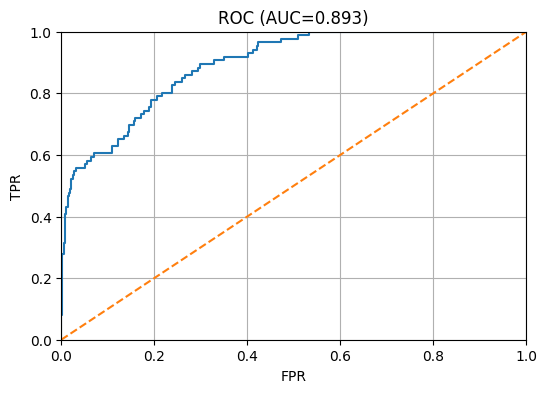

In [30]:

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_te, p_fused)
roc_val = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (AUC={roc_val:.3f})")
plt.ylim([0,1])
plt.xlim([0,1])
plt.grid(True)
plt.show()


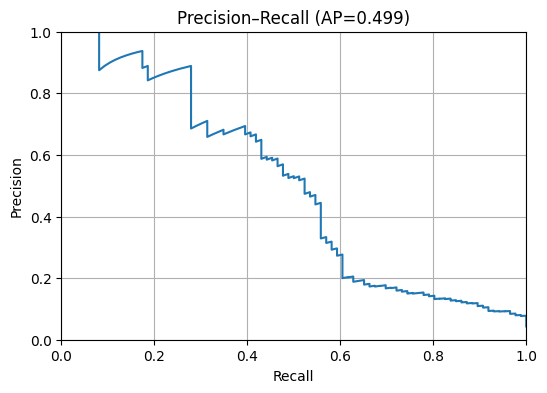

In [31]:

# Precision–Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
prec_curve, rec_curve, _ = precision_recall_curve(y_te, p_fused)
ap_val = average_precision_score(y_te, p_fused)

plt.figure(figsize=(6,4))
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (AP={ap_val:.3f})")
plt.ylim([0,1])
plt.xlim([0,1])
plt.grid(True)
plt.show()


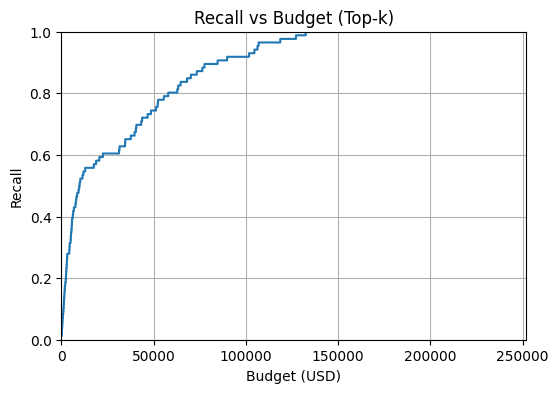

In [32]:

# Recall vs Budget
plt.figure(figsize=(6,4))
plt.step(budget_k, recall_k, where="post")
plt.xlabel("Budget (USD)"); plt.ylabel("Recall"); plt.title("Recall vs Budget (Top-k)")
plt.ylim([0,1])
plt.xlim(0)
plt.grid(True)
plt.show()


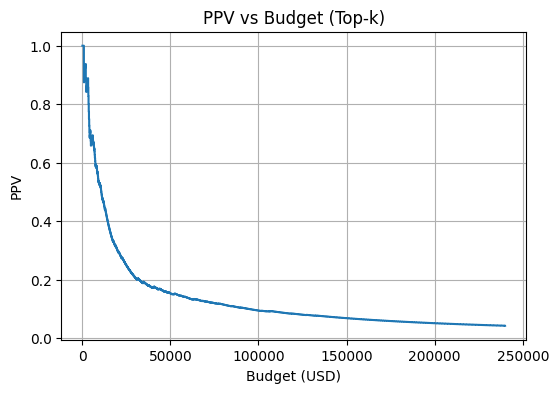

In [33]:

# PPV vs Budget
plt.figure(figsize=(6,4))
plt.step(budget_k, ppv_k, where="post")
plt.xlabel("Budget (USD)"); plt.ylabel("PPV"); plt.title("PPV vs Budget (Top-k)")
plt.grid(True)
plt.show()


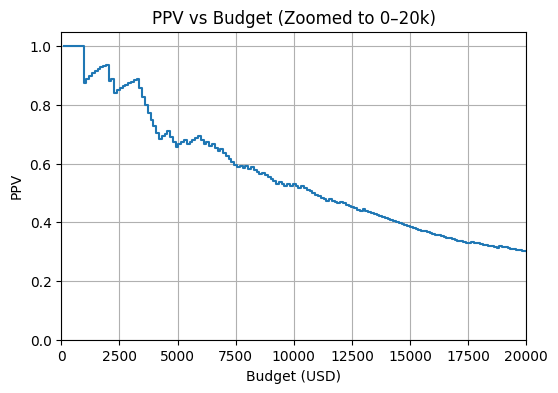

In [34]:
plt.figure(figsize=(6,4))
plt.step(budget_k, ppv_k, where="post")
plt.xlim(0, 20000)     # show only up to $20k
plt.ylim(0, 1.05)      # optional: focus PPV scale
plt.xlabel("Budget (USD)")
plt.ylabel("PPV")
plt.title("PPV vs Budget (Zoomed to 0–20k)")
plt.grid(True)
plt.show()


# Leakage-risk scan

In [35]:

# --- Leakage-risk scan (single-feature AUC) ---
def _safe_auc(y, s):
    import numpy as np
    try:
        if np.unique(s).size < 2 or np.unique(y).size < 2:
            return np.nan
        return float(roc_auc_score(y, s))
    except Exception:
        return np.nan

def scan_single_feature(df: pd.DataFrame, target: str, text_col: str=None, skip_text: bool=False) -> pd.DataFrame:
    rows = []
    y = df[target].astype(int).to_numpy()
    for col in df.columns:
        if col == target:
            continue
        if skip_text and text_col and col == text_col:
            continue
        s = df[col]

        miss_ind = (~pd.isna(s)).astype(int).to_numpy()
        rows.append({"feature": col, "variant": "missing_indicator",
                     "auc": _safe_auc(y, miss_ind),
                     "frac_missing": float(1.0 - miss_ind.mean())})

        if np.issubdtype(s.dtype, np.number):
            v = s.astype(float).to_numpy()
            m = np.isfinite(v)
            v2 = v.copy(); v2[~m] = 0.0
            nz = (v2 > 0).astype(int)
            rows.append({"feature": col, "variant": "numeric_value",
                         "auc": _safe_auc(y, v2),
                         "frac_missing": float((~m).mean())})
            rows.append({"feature": col, "variant": "numeric_nonzero",
                         "auc": _safe_auc(y, nz),
                         "frac_missing": float((~m).mean())})
        else:
            strv = s.astype(str).fillna("")
            present = (strv.str.len() > 0).astype(int).to_numpy()
            rows.append({"feature": col, "variant": "object_present",
                         "auc": _safe_auc(y, present),
                         "frac_missing": float(pd.isna(s).mean())})
    return pd.DataFrame(rows)

def aggregate_suspicion(df_long: pd.DataFrame) -> pd.DataFrame:
    if df_long.empty:
        return df_long

    g = df_long.copy()
    g["dev"] = (g["auc"] - 0.5).abs()

    # pick best variant per feature using idxmax on |AUC-0.5|
    mask = g["auc"].notna()
    if mask.any():
        idx = g.loc[mask].groupby("feature")["dev"].idxmax()
        best = g.loc[idx, ["feature", "variant", "auc", "dev"]].rename(
            columns={"variant": "best_variant", "auc": "best_auc", "dev": "suspicion"}
        )
    else:
        best = pd.DataFrame(columns=["feature", "best_variant", "best_auc", "suspicion"])

    # ensure features with all-NaN AUCs are present (suspicion = 0)
    missing = sorted(set(g["feature"].unique()) - set(best["feature"]))
    if missing:
        filler = pd.DataFrame({"feature": missing,
                               "best_variant": "n/a",
                               "best_auc": np.nan,
                               "suspicion": 0.0})
        best = pd.concat([best, filler], ignore_index=True)

    return best.reset_index(drop=True)


scan_df = scan_single_feature(df, TARGET, text_col=text_col, skip_text=False if text_col else True)
agg_df = aggregate_suspicion(scan_df).sort_values("suspicion", ascending=False).head(TOPN_LEAKAGE).reset_index(drop=True)


In [36]:
# Re-scan on RAW (normalized) data, BEFORE any drop_leakage
df_raw = utils.normalize_columns(pd.read_csv(DATA_PATH))

def _safe_auc(y, s):
    try:
        if np.unique(s).size < 2 or np.unique(y).size < 2:
            return np.nan
        return float(roc_auc_score(y, s))
    except Exception:
        return np.nan

def scan_single_feature(df: pd.DataFrame, target: str) -> pd.DataFrame:
    rows = []
    y = df[target].astype(int).to_numpy()
    for col in df.columns:
        if col == target:
            continue
        s = df[col]

        # missing indicator
        miss_ind = (~pd.isna(s)).astype(int).to_numpy()
        rows.append({"feature": col, "variant": "missing_indicator",
                     "auc": _safe_auc(y, miss_ind)})

        if np.issubdtype(s.dtype, np.number):
            v = s.astype(float).to_numpy()
            m = np.isfinite(v)
            v2 = v.copy(); v2[~m] = 0.0
            rows.append({"feature": col, "variant": "numeric_value",
                         "auc": _safe_auc(y, v2)})
            rows.append({"feature": col, "variant": "numeric_nonzero",
                         "auc": _safe_auc(y, (v2 > 0).astype(int))})
        else:
            present = s.astype(str).fillna("").str.len().gt(0).astype(int).to_numpy()
            rows.append({"feature": col, "variant": "object_present",
                         "auc": _safe_auc(y, present)})
    return pd.DataFrame(rows)

scan_df_orig = scan_single_feature(df_raw, TARGET)

# Pick the highest **raw AUC** per feature, sort desc (like your script)
mask = scan_df_orig["auc"].notna()
idx = scan_df_orig.loc[mask].groupby("feature")["auc"].idxmax()
best_auc = scan_df_orig.loc[idx, ["feature","variant","auc"]].copy()
best_auc["name_flag"] = best_auc["feature"].str.contains(utils.SUSPECT_NAME_RE, case=False, regex=True).astype(int)
best_auc = best_auc.sort_values("auc", ascending=False).reset_index(drop=True)

topN = best_auc.head(TOPN_LEAKAGE)
topN


,feature,variant,auc,name_flag
0,match_diag_141,numeric_value,0.832176,1
1,measure_blood_pressure_sys_mean_val,numeric_value,0.687621,0
2,measure_blood_pressure_dias_mean_val,numeric_value,0.687249,0
3,measure_blood_pressure_sys_last_val,numeric_value,0.681887,0
4,measure_blood_pressure_dias_last_val,numeric_value,0.681103,0
5,measure_blood_pressure_dias_max_val,numeric_value,0.678869,0
6,measure_blood_pressure_sys_max_val,numeric_value,0.677607,0
7,measure_blood_pressure_sys_min_val,numeric_value,0.667112,0
8,measure_blood_pressure_dias_min_val,numeric_value,0.663632,0
9,measure_blood_pressure_sys_first_val,numeric_value,0.661379,0


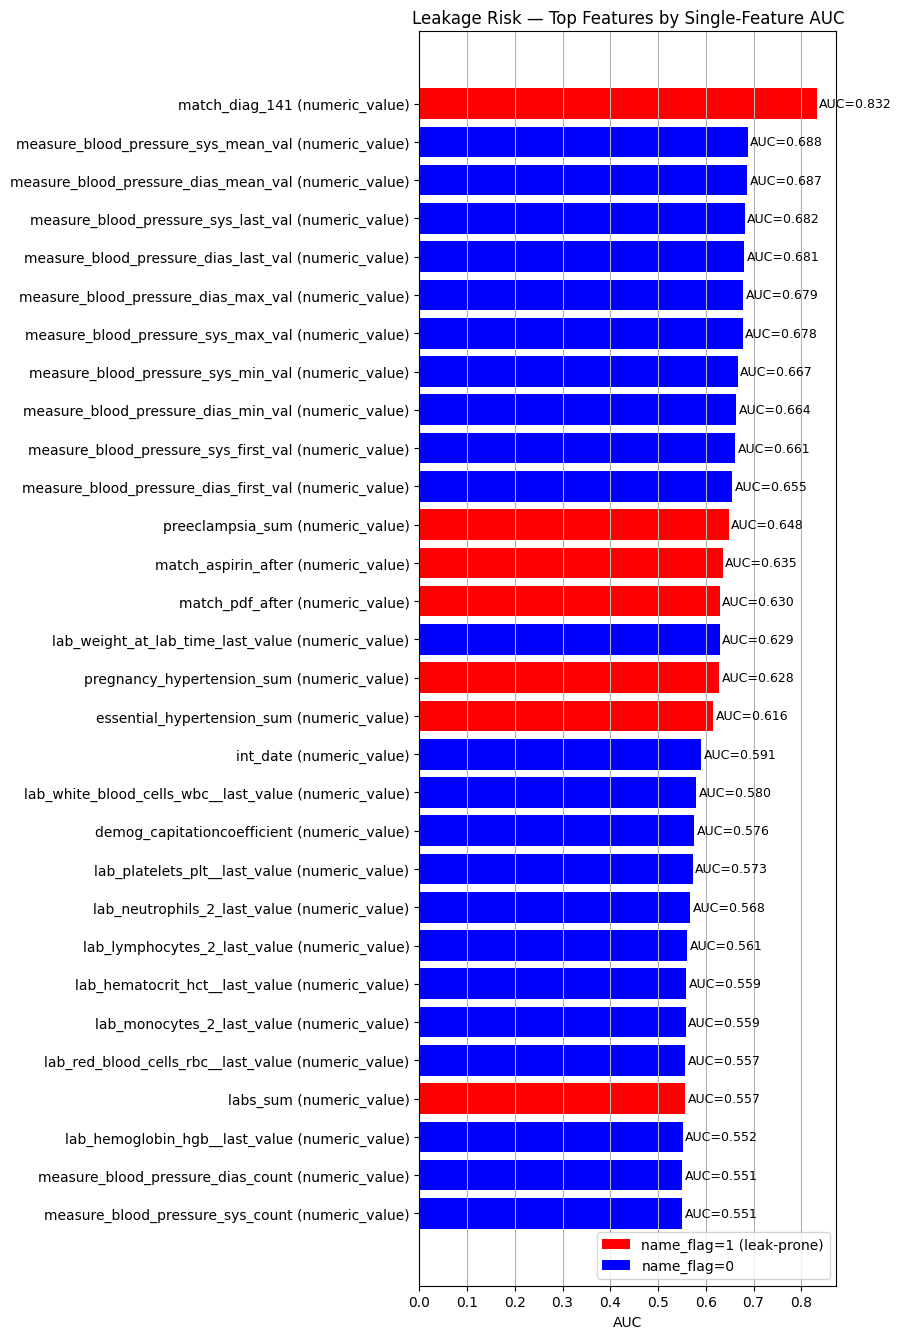

In [37]:
# Force white background (ignore notebook theme)
plt.rcParams.update({"figure.facecolor":"white","axes.facecolor":"white"})

dfp = topN.iloc[::-1].reset_index(drop=True)  # bottom→top
ypos = np.arange(len(dfp))
vals = dfp["auc"].to_numpy()
flag = dfp["name_flag"].to_numpy().astype(bool)

plt.figure(figsize=(9, max(5, 0.45*len(dfp))))
# base bars (blue-ish default)
plt.barh(ypos, vals)
# overlay flagged in red
plt.barh(ypos[flag], vals[flag], color="red", label="name_flag=1 (leak-prone)")
plt.barh(ypos[~flag], vals[~flag], color='blue', label="name_flag=0")

labels = [f"{f} ({v})" for f, v in zip(dfp["feature"], dfp["variant"])]
plt.yticks(ypos, labels)
for i, v in enumerate(vals):
    plt.text(v + 0.005, i, f"AUC={v:.3f}", va="center", fontsize=9)

plt.xlabel("AUC")
plt.title("Leakage Risk — Top Features by Single-Feature AUC")
plt.grid(axis="x")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
